# UBC-MDS/DSCI_522_group_401
# Predicting Medical Insurance Cost
Authors: Karanpal Singh, Sreejith Munthikodu, Sirine Chahma  
[Data Source](https://gist.github.com/meperezcuello/82a9f1c1c473d6585e750ad2e3c05a41)

# Import libraries and packages

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV


from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error


ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (/home/sree/anaconda3/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

# Load training data

In [208]:
medical_data = pd.read_csv("../data/processed/medical_cost_data_training.csv")
X = medical_data.drop("charges", axis=1)
y = medical_data.charges
medical_data.head()

,age,sex,bmi,children,smoker,region,charges
0,36,male,27.55,3,no,northeast,6746.7425
1,60,female,35.10,0,no,southwest,12644.5890
2,30,male,31.57,3,no,southeast,4837.5823
3,49,male,25.60,2,yes,southwest,23306.5470
4,26,male,32.90,2,yes,southwest,36085.2190


In [210]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify categoric and numeric features

In [244]:
# Identify categoric and numeric features
def get_cat_num_features(x):
    data_types = x.dtypes
    categoric_features = []
    numeric_features = []
    for d_type, feature in zip(data_types, data_types.index):
        if d_type == "object":
            categoric_features.append(feature)
        else:
            numeric_features.append(feature)
    return categoric_features, numeric_features

categoric_features, numeric_features = get_cat_num_features(X)

# Create a preprocessing pipeline

In [212]:
numeric_transformer = Pipeline(steps=[("poly" , PolynomialFeatures(degree=3)),
                                      ("scaler", StandardScaler())])
categoric_transformer = Pipeline(steps=[("ohe", OneHotEncoder())])

preprocessor = ColumnTransformer(transformers = [
                                 ("num", numeric_transformer, numeric_features),
                                 ("cat", categoric_transformer, categoric_features)])

# No Free Lunch - Try various models

1. linear regression
2. Decisiontree regression
3. knnregression
4. Randomforestregression
5. polynomial regression (Try polynomial features later)
6. support vector machines
 

In [261]:
models = {
    "linear_regression" : LinearRegression(),
    "decision_tree_regressor" : DecisionTreeRegressor(),
    "knn_regression" : KNeighborsRegressor(),
    "rf_regression" : RandomForestRegressor(n_estimators=100),
    "SVR" : SVR(gamma="scale")   
}

In [262]:
X_train.shape

(655, 6)

In [263]:
y_train.shape

(655,)

In [276]:
def try_models(models, X_train, y_train, preprocessor):
    results_dict = {}
    print(y_train.shape)
    for model_name, model in models.items():
        print(f"trainning {model}")
        t = time.time()
        reg = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', model)])
        validation_error = np.mean(cross_val_score(reg, X_train, 
                                                   y_train, 
                                                   scoring = "neg_mean_absolute_error", 
                                                   cv=5) * -1)
        reg.fit(X_train, y_train)
        tr_err = mean_absolute_error(y_train, reg.predict(X_train))
        elapsed_time = time.time() - t
        results_dict[model_name] = [np.round(tr_err,3), np.round(validation_error,3), np.round(elapsed_time,4)]
        indices = ["Mean absolute error, training", "Mean absolute error, test", "training_time(s)"]
    results_df = pd.DataFrame(results_dict)
    results_df.index = indices
    return results_df
results_df = try_models(models, X_train, y_train, preprocessor)
results_df

(655,)
trainning LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
trainning DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
trainning KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
trainning RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estima

,linear_regression,decision_tree_regressor,knn_regression,rf_regression,SVR
"Mean absolute error, training",4541.9410,0.0000,3268.7340,1151.1690,8625.7510
"Mean absolute error, test",4593.5290,3711.8030,4242.7680,3174.5240,8631.4270
training_time(s),0.1395,0.0951,0.0968,1.0848,0.1767


In [229]:
pd.DataFrame(results_dict).T

,0,1,2
linear_regression,4339.149,4380.674,0.0215
decision_tree_regressor,0.000,3920.122,0.0359
knn_regression,4360.787,5479.350,0.0464
rf_regression,1243.239,2925.175,0.0736
SVR,8622.600,7868.797,0.0662


# Hyperparameter optimization of DecisionTreeRegressor

In [232]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', DecisionTreeRegressor())])

param_grid = {
    'preprocessor__num__poly__degree': list(range(1, 5)),
    'regressor__max_depth': list(range(1, 20)),
    "regressor__min_samples_split" : list(range(2, 10))
}

grid_search = GridSearchCV(clf, param_grid, cv=5, return_train_score=True, scoring="neg_mean_absolute_error")
grid_search.fit(X, y)



/home/sree/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('poly',
                                                                                          PolynomialFeatures(degree=3,
                                                                                                             include_bias=True,
                

In [233]:
print(mean_absolute_error(y_train, grid_search.predict(X_train)))
print(mean_absolute_error(y_test, grid_search.predict(X_test)))

2441.5282332272454
2735.7976303364367


In [236]:
grid_results

,train_score,test_score
0,5743.088522,5760.315666
1,5743.088522,5760.315666
2,5743.088522,5760.315666
3,5743.088522,5760.315666
4,5743.088522,5760.315666
...,...,...
603,627.290987,3319.338428
604,772.737610,3058.400595
605,899.223364,3139.133493
606,1000.096318,3143.752292


In [219]:
train_score = grid_search.cv_results_["mean_train_score"] * -1
test_score = grid_search.cv_results_["mean_test_score"] * -1
grid_results = pd.DataFrame({"train_score" : train_score, "test_score" : test_score})
# grid_results["max_depth"] = list(range(1, 20))

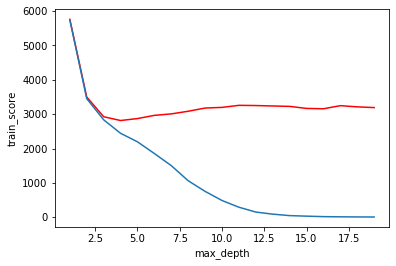

In [108]:
# sns.lineplot("max_depth", "test_score", data=grid_results, color="r")
# sns.lineplot("max_depth", "train_score", data=grid_results)

# Best model

In [237]:
 grid_search.best_params_

{'preprocessor__num__poly__degree': 1,
 'regressor__max_depth': 5,
 'regressor__min_samples_split': 4}

In [238]:
numeric_transformer = Pipeline(steps=[("poly" , PolynomialFeatures(degree=1)),
                                      ("scaler", StandardScaler())])
categoric_transformer = Pipeline(steps=[("ohe", OneHotEncoder())])

preprocessor = ColumnTransformer(transformers = [
                                 ("num", numeric_transformer, numeric_features),
                                 ("cat", categoric_transformer, categoric_features)])

In [239]:
reg = RandomForestRegressor(max_depth=5, min_samples_split=4)
model = Pipeline(steps = [("preprocessor", preprocessor),
                         ("regressor", reg)])

model.fit(X, y)

/home/sree/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=True,
                                                                                      interaction_only=False,
                                                                                      order='C')),
                                                                  ('scaler',
                                                                   Sta

In [240]:
mean_absolute_error(y, model.predict(X))

2280.1845667722278

# Load test data and test

In [241]:
medical_data_test = pd.read_csv("../data/processed/medical_cost_data_test.csv")
X_test = medical_data_test.drop("charges", axis=1)
y_test = medical_data_test.charges

In [242]:
mean_absolute_error(y_test, model.predict(X_test))

2455.62435350827